In [ ]:
!pip install opendatasets


In [ ]:
import opendatasets as od

In [ ]:
od.download('https://www.kaggle.com/datasets/rigvedshirvalkar/alzheimer-roboflow-classification-dataset')

Skipping, found downloaded files in "./alzheimer-roboflow-classification-dataset" (use force=True to force download)


In [ ]:
pip install opencv-python

In [ ]:
import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
import torchvision.transforms as T
import torch.utils.data as data
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import Dataset, TensorDataset, random_split


import seaborn as sns

In [ ]:
data_dir = '/content/alzheimer-roboflow-classification-dataset'

In [ ]:
norm=((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

In [ ]:
train_transform = T.Compose([
    T.ToTensor(),
    T.Resize((224,224)),
    T.Normalize(*norm,inplace=True),
    T.RandomErasing(p=0.3,scale=(0.02,0.2)),
    T.RandomVerticalFlip(p=0.25),
    T.RandomHorizontalFlip(p=0.25),
    T.RandomRotation(10)
    ])

test_transform = T.Compose([
    T.ToTensor(),
    T.Resize((224,224)),
    T.Normalize(*norm,inplace=True)
    ])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cuda'

In [ ]:
train_dataset=datasets.ImageFolder(data_dir + '/train', transform=train_transform)
test_dataset=datasets.ImageFolder(data_dir + '/test', transform=test_transform)
val_dataset=datasets.ImageFolder(data_dir + '/valid', transform=test_transform)

In [ ]:
print('Размер тренировочной выборки: {}'.format(len(train_dataset)))
print('Размер валидационной выборки: {}'.format(len(val_dataset)))
print('Размер тестовой выборки: {}'.format(len(test_dataset)))

Размер тренировочной выборки: 6929
Размер валидационной выборки: 95
Размер тестовой выборки: 2876


In [ ]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, indices=None, num_samples=None):

        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples

        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1

        weights  = [1.0 for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is torchvision.datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is torchvision.datasets.ImageFolder:
            return dataset.imgs[idx][1]
        else:
            return dataset.__getitem__(idx)[1]

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [ ]:
#batch_size=32
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=False, sampler=ImbalancedDatasetSampler(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

In [ ]:
def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

In [ ]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        unnorm_images = unnorm(images, *norm)
        ax.imshow(make_grid(unnorm_images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

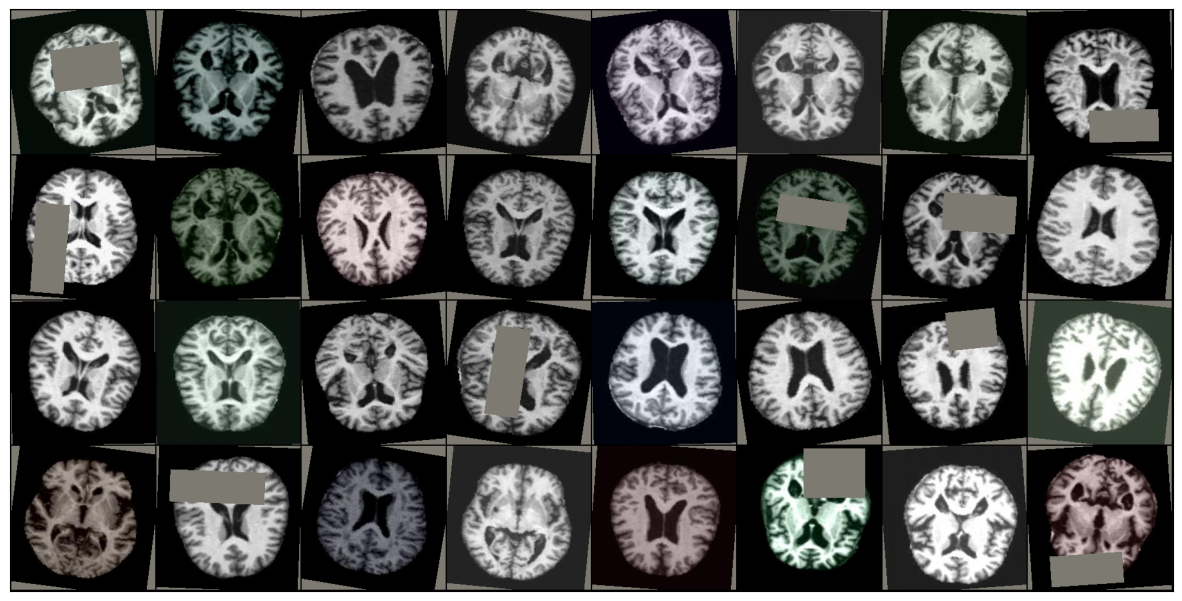

In [ ]:
show_batch(train_loader)

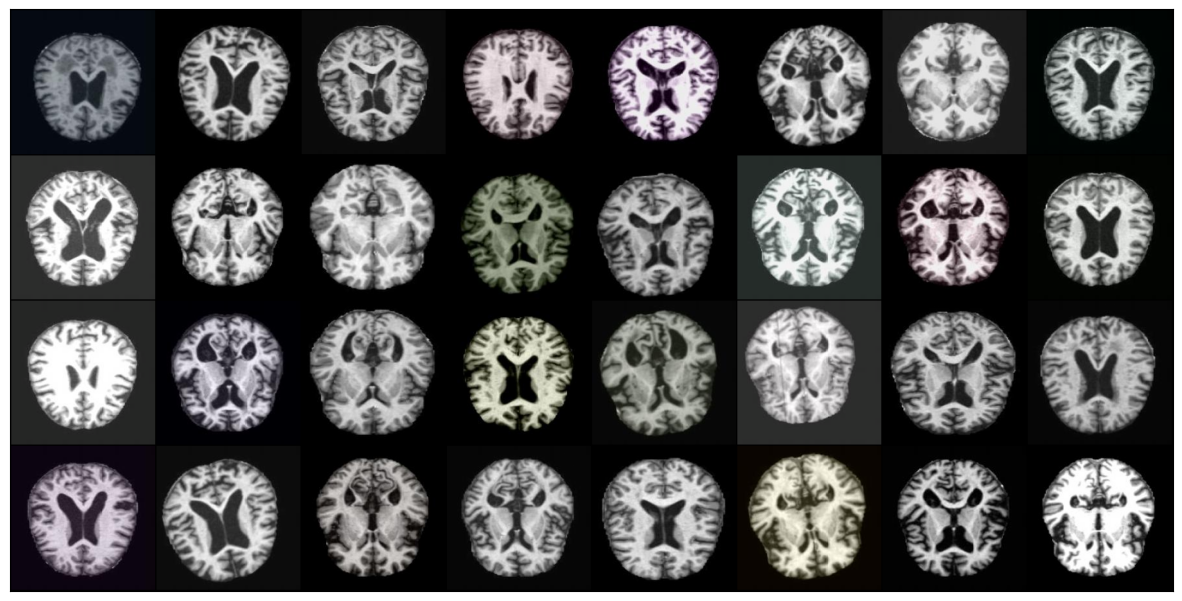

In [ ]:
show_batch(test_loader)

In [ ]:
! pip install timm --quiet

In [ ]:
import timm

In [ ]:
len(train_dataset.classes)

4

In [ ]:
model = timm.create_model('mobilenetv4_conv_small.e2400_r224_in1k', pretrained=True,
                          num_classes=len(train_dataset.classes))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
! pip install torchinfo --quiet

In [ ]:
from torchinfo import summary
summary(model,input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 4]                    --
├─Conv2d: 1-1                                      [1, 32, 112, 112]         864
├─BatchNormAct2d: 1-2                              [1, 32, 112, 112]         64
│    └─Identity: 2-1                               [1, 32, 112, 112]         --
│    └─ReLU: 2-2                                   [1, 32, 112, 112]         --
├─Sequential: 1-3                                  [1, 960, 7, 7]            --
│    └─Sequential: 2-3                             [1, 32, 56, 56]           --
│    │    └─ConvBnAct: 3-1                         [1, 32, 56, 56]           9,280
│    │    └─ConvBnAct: 3-2                         [1, 32, 56, 56]           1,088
│    └─Sequential: 2-4                             [1, 64, 28, 28]           --
│    │    └─ConvBnAct: 3-3                         [1, 96, 28, 28]           27,840
│    │    └─ConvBnAct: 3

In [ ]:
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm

In [ ]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

In [ ]:
train_losses=[]
train_accs=[]
def train(model,epoch):
  print('\nEpoch : %d'%epoch)
  model.train() # веса модели можно обновлять
  running_loss= 0.
  running_acc = 0.
  for data in tqdm(train_loader):
      inputs, targets=data[0].to(device),data[1].to(device) # распаковываем пакеты
      optimizer.zero_grad() # обнуляем градиенты
      outputs=model(inputs) # считаем предсказания - прямой проход модели
      loss=criterion(outputs,targets) # ошибка пакета
      loss.backward() # обратное распространение ошибки
      optimizer.step() # итерация алгоритма оптимизации

      running_loss += loss.item()
      running_acc += accuracy(outputs,targets)

  train_loss=running_loss/len(train_loader)
  train_acc=running_acc/len(train_loader)

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  print('Средняя ошибка модели на тренировочной выборке: %.4f'%(train_loss)+'   Средняя точность модели на тренировочной выборке: %.4f'%(train_acc))

In [ ]:
val_losses=[]
val_accs=[]
def val(model,epoch):
    print('\nEpoch : %d'%epoch)
    model.eval() # веса модели заморожены
    running_loss = 0.
    running_acc = 0.
    with torch.no_grad(): # запрещаем переисывать градиенты
        for data in tqdm(val_loader):
            inputs, targets=data[0].to(device),data[1].to(device)
            outputs=model(inputs)
            loss=criterion(outputs,targets)

            running_loss += loss.item()
            running_acc += accuracy(outputs,targets)

        val_loss=running_loss/len(val_loader)
        val_acc=running_acc/len(val_loader)

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print('Средняя ошибка модели на валидационной выборке: %.4f'%(val_loss)+'   Средняя точность модели на валидационной выборке: %.4f'%(val_acc))

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
%%time
max_epochs=100
best_acc=0.0
early_stopper = EarlyStopper(patience=5, min_delta=0.001)
for epoch in range(1,max_epochs+1):
    train(model,epoch)
    val(model,epoch)
    if (val_accs[-1] > best_acc):
       torch.save(model, 'best-model.pt')
       best_acc = val_accs[-1]
    if (early_stopper.early_stop(val_losses[-1])):
      break


Epoch : 1


100%|██████████| 217/217 [00:57<00:00,  3.80it/s]


Средняя ошибка модели на тренировочной выборке: 1.5511   Средняя точность модели на тренировочной выборке: 0.4132

Epoch : 1


100%|██████████| 3/3 [00:00<00:00, 12.00it/s]


Средняя ошибка модели на валидационной выборке: 1.1059   Средняя точность модели на валидационной выборке: 0.5161

Epoch : 2


100%|██████████| 217/217 [00:47<00:00,  4.53it/s]


Средняя ошибка модели на тренировочной выборке: 0.9757   Средняя точность модели на тренировочной выборке: 0.5576

Epoch : 2


100%|██████████| 3/3 [00:00<00:00, 15.28it/s]


Средняя ошибка модели на валидационной выборке: 0.9204   Средняя точность модели на валидационной выборке: 0.5796

Epoch : 3


100%|██████████| 217/217 [00:45<00:00,  4.73it/s]


Средняя ошибка модели на тренировочной выборке: 0.8440   Средняя точность модели на тренировочной выборке: 0.6159

Epoch : 3


100%|██████████| 3/3 [00:00<00:00, 14.43it/s]


Средняя ошибка модели на валидационной выборке: 1.1095   Средняя точность модели на валидационной выборке: 0.5581

Epoch : 4


100%|██████████| 217/217 [00:46<00:00,  4.63it/s]


Средняя ошибка модели на тренировочной выборке: 0.8097   Средняя точность модели на тренировочной выборке: 0.6328

Epoch : 4


100%|██████████| 3/3 [00:00<00:00, 14.44it/s]


Средняя ошибка модели на валидационной выборке: 1.1474   Средняя точность модели на валидационной выборке: 0.5474

Epoch : 5


100%|██████████| 217/217 [00:45<00:00,  4.77it/s]


Средняя ошибка модели на тренировочной выборке: 0.7498   Средняя точность модели на тренировочной выборке: 0.6673

Epoch : 5


100%|██████████| 3/3 [00:00<00:00, 14.43it/s]


Средняя ошибка модели на валидационной выборке: 0.7222   Средняя точность модели на валидационной выборке: 0.7046

Epoch : 6


100%|██████████| 217/217 [00:46<00:00,  4.67it/s]


Средняя ошибка модели на тренировочной выборке: 0.6946   Средняя точность модели на тренировочной выборке: 0.6907

Epoch : 6


100%|██████████| 3/3 [00:00<00:00, 12.25it/s]


Средняя ошибка модели на валидационной выборке: 0.6899   Средняя точность модели на валидационной выборке: 0.6623

Epoch : 7


100%|██████████| 217/217 [00:45<00:00,  4.72it/s]


Средняя ошибка модели на тренировочной выборке: 0.6943   Средняя точность модели на тренировочной выборке: 0.6986

Epoch : 7


100%|██████████| 3/3 [00:00<00:00, 15.13it/s]


Средняя ошибка модели на валидационной выборке: 0.5978   Средняя точность модели на валидационной выборке: 0.7789

Epoch : 8


100%|██████████| 217/217 [00:45<00:00,  4.75it/s]


Средняя ошибка модели на тренировочной выборке: 0.6514   Средняя точность модели на тренировочной выборке: 0.7144

Epoch : 8


100%|██████████| 3/3 [00:00<00:00, 13.37it/s]


Средняя ошибка модели на валидационной выборке: 0.6556   Средняя точность модели на валидационной выборке: 0.7265

Epoch : 9


100%|██████████| 217/217 [00:46<00:00,  4.67it/s]


Средняя ошибка модели на тренировочной выборке: 0.6240   Средняя точность модели на тренировочной выборке: 0.7305

Epoch : 9


100%|██████████| 3/3 [00:00<00:00, 15.49it/s]


Средняя ошибка модели на валидационной выборке: 0.6597   Средняя точность модели на валидационной выборке: 0.6831

Epoch : 10


100%|██████████| 217/217 [00:45<00:00,  4.79it/s]


Средняя ошибка модели на тренировочной выборке: 0.6184   Средняя точность модели на тренировочной выборке: 0.7409

Epoch : 10


100%|██████████| 3/3 [00:00<00:00, 15.72it/s]


Средняя ошибка модели на валидационной выборке: 0.9005   Средняя точность модели на валидационной выборке: 0.6522

Epoch : 11


100%|██████████| 217/217 [00:46<00:00,  4.69it/s]


Средняя ошибка модели на тренировочной выборке: 0.5991   Средняя точность модели на тренировочной выборке: 0.7515

Epoch : 11


100%|██████████| 3/3 [00:00<00:00, 15.38it/s]


Средняя ошибка модели на валидационной выборке: 0.4483   Средняя точность модели на валидационной выборке: 0.7897

Epoch : 12


100%|██████████| 217/217 [00:45<00:00,  4.76it/s]


Средняя ошибка модели на тренировочной выборке: 0.5922   Средняя точность модели на тренировочной выборке: 0.7430

Epoch : 12


100%|██████████| 3/3 [00:00<00:00, 15.04it/s]


Средняя ошибка модели на валидационной выборке: 0.5548   Средняя точность модели на валидационной выборке: 0.7581

Epoch : 13


100%|██████████| 217/217 [00:46<00:00,  4.70it/s]


Средняя ошибка модели на тренировочной выборке: 0.5594   Средняя точность модели на тренировочной выборке: 0.7586

Epoch : 13


100%|██████████| 3/3 [00:00<00:00, 12.61it/s]


Средняя ошибка модели на валидационной выборке: 0.3901   Средняя точность модели на валидационной выборке: 0.8636

Epoch : 14


100%|██████████| 217/217 [00:45<00:00,  4.72it/s]


Средняя ошибка модели на тренировочной выборке: 0.5259   Средняя точность модели на тренировочной выборке: 0.7782

Epoch : 14


100%|██████████| 3/3 [00:00<00:00, 15.37it/s]

Средняя ошибка модели на валидационной выборке: 0.4668   Средняя точность модели на валидационной выборке: 0.7897



Epoch : 15


100%|██████████| 217/217 [00:45<00:00,  4.77it/s]


Средняя ошибка модели на тренировочной выборке: 0.5455   Средняя точность модели на тренировочной выборке: 0.7741

Epoch : 15


100%|██████████| 3/3 [00:00<00:00, 15.70it/s]


Средняя ошибка модели на валидационной выборке: 0.5348   Средняя точность модели на валидационной выборке: 0.7893

Epoch : 16


100%|██████████| 217/217 [00:46<00:00,  4.68it/s]


Средняя ошибка модели на тренировочной выборке: 0.5045   Средняя точность модели на тренировочной выборке: 0.7942

Epoch : 16


100%|██████████| 3/3 [00:00<00:00, 14.76it/s]


Средняя ошибка модели на валидационной выборке: 0.6205   Средняя точность модели на валидационной выборке: 0.7574

Epoch : 17


100%|██████████| 217/217 [00:45<00:00,  4.79it/s]


Средняя ошибка модели на тренировочной выборке: 0.5712   Средняя точность модели на тренировочной выборке: 0.7615

Epoch : 17


100%|██████████| 3/3 [00:00<00:00, 15.57it/s]


Средняя ошибка модели на валидационной выборке: 0.5012   Средняя точность модели на валидационной выборке: 0.7571

Epoch : 18


100%|██████████| 217/217 [00:45<00:00,  4.74it/s]


Средняя ошибка модели на тренировочной выборке: 0.5074   Средняя точность модели на тренировочной выборке: 0.7862

Epoch : 18


100%|██████████| 3/3 [00:00<00:00, 11.39it/s]


Средняя ошибка модели на валидационной выборке: 0.3676   Средняя точность модели на валидационной выборке: 0.8216

Epoch : 19


100%|██████████| 217/217 [00:45<00:00,  4.79it/s]


Средняя ошибка модели на тренировочной выборке: 0.4852   Средняя точность модели на тренировочной выборке: 0.8021

Epoch : 19


100%|██████████| 3/3 [00:00<00:00, 14.67it/s]


Средняя ошибка модели на валидационной выборке: 0.4606   Средняя точность модели на валидационной выборке: 0.7997

Epoch : 20


100%|██████████| 217/217 [00:45<00:00,  4.79it/s]


Средняя ошибка модели на тренировочной выборке: 0.4557   Средняя точность модели на тренировочной выборке: 0.8060

Epoch : 20


100%|██████████| 3/3 [00:00<00:00, 14.58it/s]


Средняя ошибка модели на валидационной выборке: 0.3640   Средняя точность модели на валидационной выборке: 0.8528

Epoch : 21


100%|██████████| 217/217 [00:46<00:00,  4.66it/s]


Средняя ошибка модели на тренировочной выборке: 0.4557   Средняя точность модели на тренировочной выборке: 0.8186

Epoch : 21


100%|██████████| 3/3 [00:00<00:00, 15.99it/s]


Средняя ошибка модели на валидационной выборке: 0.7103   Средняя точность модели на валидационной выборке: 0.6835

Epoch : 22


100%|██████████| 217/217 [00:45<00:00,  4.74it/s]


Средняя ошибка модели на тренировочной выборке: 0.4448   Средняя точность модели на тренировочной выборке: 0.8215

Epoch : 22


100%|██████████| 3/3 [00:00<00:00, 15.53it/s]


Средняя ошибка модели на валидационной выборке: 0.3372   Средняя точность модели на валидационной выборке: 0.8626

Epoch : 23


100%|██████████| 217/217 [00:46<00:00,  4.70it/s]


Средняя ошибка модели на тренировочной выборке: 0.4114   Средняя точность модели на тренировочной выборке: 0.8356

Epoch : 23


100%|██████████| 3/3 [00:00<00:00, 14.86it/s]


Средняя ошибка модели на валидационной выборке: 0.2860   Средняя точность модели на валидационной выборке: 0.8952

Epoch : 24


100%|██████████| 217/217 [00:45<00:00,  4.79it/s]


Средняя ошибка модели на тренировочной выборке: 0.4513   Средняя точность модели на тренировочной выборке: 0.8182

Epoch : 24


100%|██████████| 3/3 [00:00<00:00, 15.57it/s]


Средняя ошибка модели на валидационной выборке: 0.5840   Средняя точность модели на валидационной выборке: 0.7692

Epoch : 25


100%|██████████| 217/217 [00:45<00:00,  4.73it/s]


Средняя ошибка модели на тренировочной выборке: 0.4398   Средняя точность модели на тренировочной выборке: 0.8179

Epoch : 25


100%|██████████| 3/3 [00:00<00:00, 12.63it/s]


Средняя ошибка модели на валидационной выборке: 0.2336   Средняя точность модели на валидационной выборке: 0.9150

Epoch : 26


100%|██████████| 217/217 [00:45<00:00,  4.75it/s]


Средняя ошибка модели на тренировочной выборке: 0.4265   Средняя точность модели на тренировочной выборке: 0.8331

Epoch : 26


100%|██████████| 3/3 [00:00<00:00, 15.11it/s]


Средняя ошибка модели на валидационной выборке: 0.5691   Средняя точность модели на валидационной выборке: 0.7480

Epoch : 27


100%|██████████| 217/217 [00:45<00:00,  4.78it/s]


Средняя ошибка модели на тренировочной выборке: 0.4139   Средняя точность модели на тренировочной выборке: 0.8389

Epoch : 27


100%|██████████| 3/3 [00:00<00:00, 14.39it/s]


Средняя ошибка модели на валидационной выборке: 0.4390   Средняя точность модели на валидационной выборке: 0.8844

Epoch : 28


100%|██████████| 217/217 [00:46<00:00,  4.70it/s]


Средняя ошибка модели на тренировочной выборке: 0.3809   Средняя точность модели на тренировочной выборке: 0.8500

Epoch : 28


100%|██████████| 3/3 [00:00<00:00, 15.36it/s]


Средняя ошибка модели на валидационной выборке: 0.2935   Средняя точность модели на валидационной выборке: 0.9153

Epoch : 29


100%|██████████| 217/217 [00:45<00:00,  4.79it/s]


Средняя ошибка модели на тренировочной выборке: 0.3598   Средняя точность модели на тренировочной выборке: 0.8555

Epoch : 29


100%|██████████| 3/3 [00:00<00:00, 15.30it/s]


Средняя ошибка модели на валидационной выборке: 0.2347   Средняя точность модели на валидационной выборке: 0.9160

Epoch : 30


100%|██████████| 217/217 [00:46<00:00,  4.67it/s]


Средняя ошибка модели на тренировочной выборке: 0.3382   Средняя точность модели на тренировочной выборке: 0.8673

Epoch : 30


100%|██████████| 3/3 [00:00<00:00, 11.89it/s]

Средняя ошибка модели на валидационной выборке: 0.3056   Средняя точность модели на валидационной выборке: 0.8837
CPU times: user 22min 37s, sys: 15.8 s, total: 22min 52s
Wall time: 23min 16s


In [ ]:
print('Лучшая точность на валидации: {}%'.format(round(100*best_acc.to('cpu').numpy(),3)))

Лучшая точность на валидации: 91.5989990234375%


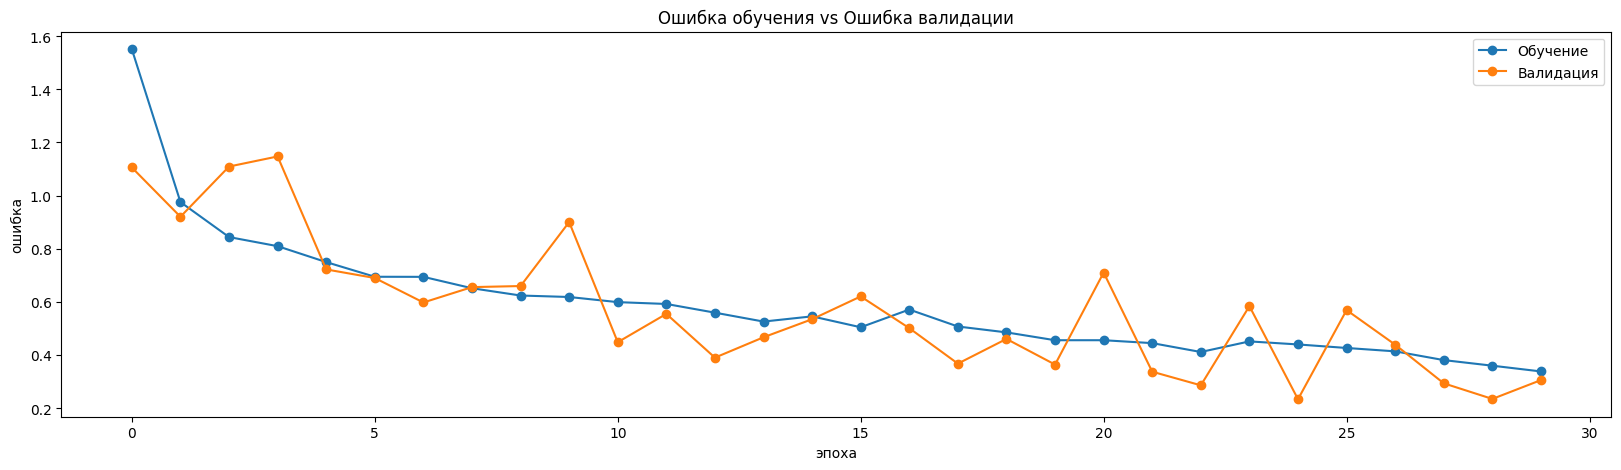

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('эпоха')
plt.ylabel('ошибка')
plt.legend(['Обучение','Валидация'])
plt.title('Ошибка обучения vs Ошибка валидации')
plt.show()

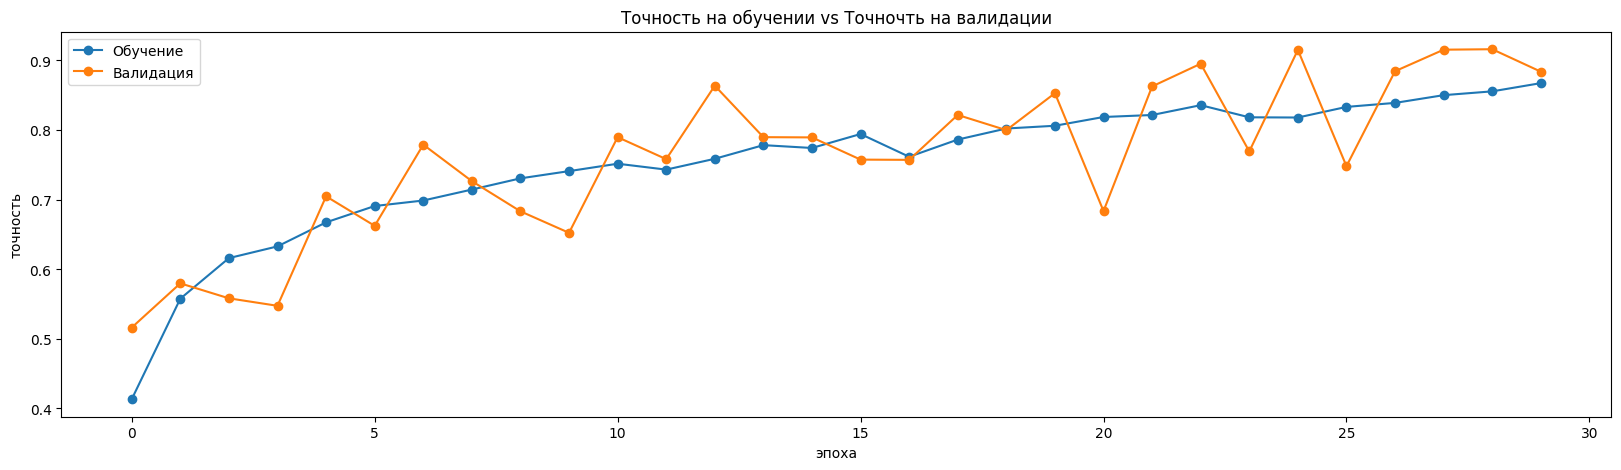

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot([x.to('cpu').numpy() for x in train_accs],'-o')
plt.plot([x.to('cpu').numpy() for x in val_accs],'-o')
plt.xlabel('эпоха')
plt.ylabel('точность')
plt.legend(['Обучение','Валидация'])
plt.title('Точность на обучении vs Точночть на валидации')
plt.show()

In [ ]:
model = torch.load('best-model.pt',weights_only=False);
model.eval();

In [ ]:
preds=[]
trgts=[]
with torch.no_grad():
  for data in tqdm(test_loader):
    inputs, targets=data[0].to(device),data[1].to(device)
    outputs=model(inputs)
    targets=targets.to('cpu').numpy()
    pred = outputs.data.max(1, keepdim=True)[1]
    pred = pred.to('cpu').numpy()
    trgts.append(targets)
    preds.append(pred)

100%|██████████| 90/90 [00:07<00:00, 12.27it/s]


In [ ]:
targets=[x for sub in trgts for x in sub]
predictions=[x[0] for sub in preds for x in sub]
targets=np.array(targets)
predictions=np.array(predictions)

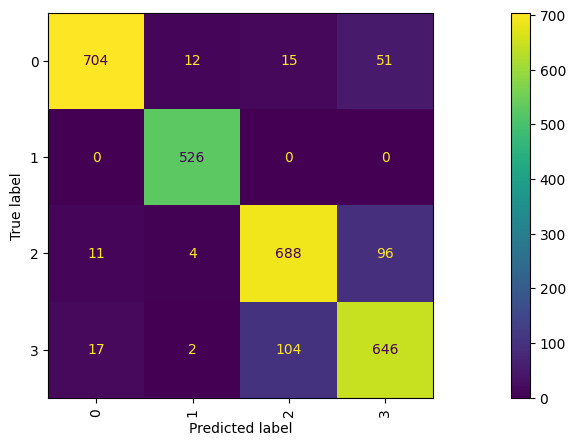

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
ConfusionMatrixDisplay.from_predictions(targets, predictions,
                                        #display_labels=train_dataset.classes,
                                        xticks_rotation='vertical')

In [ ]:
print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       782
           1       0.97      1.00      0.98       526
           2       0.85      0.86      0.86       799
           3       0.81      0.84      0.83       769

    accuracy                           0.89      2876
   macro avg       0.90      0.90      0.90      2876
weighted avg       0.89      0.89      0.89      2876

